# TAMU Datathon Walmart Problem Description

This document will walk you through understanding the steps that lead to your problem statement. It also contains all necessary helper functions for you to develop your system. You may use any algorithm you like to solve this problem.

The problem you are being asked to solve is a variation on the Traveling Salesman Problem. Given a map of a Walmart store, a set of points (targets), and a traffic density map (weights), determine the shortest path between all points which does not go through impassable locations (i.d. product displays) and minimizes the "travel time" subject to the traffic density constraint.

You can assume traffic density acts as a additive slowdown, such that a "0" indicates no slowdown passing through that location, a "1" indicates the maximum possible slowdown. An infinity indicates complete impassability. Your path is required to pass through all target points (guaranteed to be "0"s) such that the sum of the weights along your route is minimal. 

You will be judged based on a set of seeds (every participate is judged using the same seeds) and the winner is the one whose total path is shortest (subject to the constraints) across all tested scenarios. You are highly encouraged to run your own tests to determine how flexible your algorithm is using random noise and targets. Helper functions for this are presented at the bottom. If no participants can find a non-infinite path, that seed will not be judged.

In the case of ties, runtime will be used as a tie breaker. All runtimes are limited to 1 minute per run (approximately, as system specifications may change this).

Before beginning, you may find it helpful to step through this notebook, which illustrates how the random noise and points are generated. Alternatively, you can skip to using the functions in question at the bottom of the notebook.

First, we'll establish some helper functions we'll use throughout the notebook. These allow for displaying of images and generation of noise.

-- Problems by Kevin Horecka(kevin.horecka@walmart.com)

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

def display_img(img, title="Store Map", figsize=(15, 10), cmap='gray', minmax=True):
    plt.figure(figsize=figsize)
    if minmax:
        plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

def perlin(x, y, seed=0):
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi
    u = fade(xf)
    v = fade(yf)
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

def lerp(a, b, x):
    return a + x * (b - a)

def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def generate_noise_image(width, height, origin=0, scale_factor=5, seed=2):
    size = max([width, height])
    scale_x = width / size
    scale_y = height / size
    X = np.linspace(origin, scale_factor * scale_x, width, endpoint=False)
    Y = np.linspace(origin, scale_factor * scale_y, height, endpoint=False)
    x, y = np.meshgrid(X, Y)
    noise_img = perlin(x, y, seed=seed)
    return noise_img

## Critical Hyperparameters

Next, we're going to establish our critical hyperparameters. Note that the noise seeds will change when your solution is tested. Most other values do not impact performance and are for visualization only.

In [2]:
image_map_source_filename = '1150.png' # The store map file location
target_seed = 42 # For determining the random target locations
noise_seed = 42 # For determining the random traffic noise locations

N_targets = 50 # The number of targets to be generated
circle_draw_size = 20 # Radius of targets to draw on goal image

## Preparing the Maps

First, we'll load the map image and binarize it. 

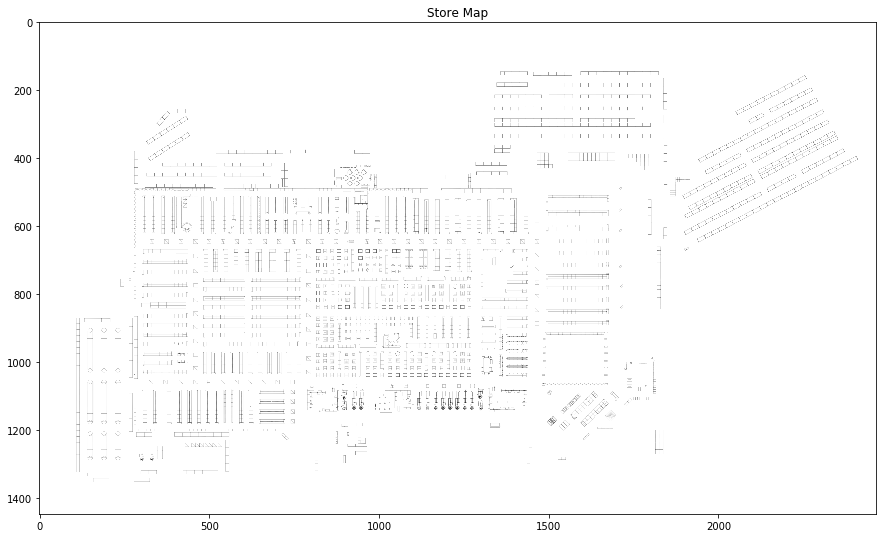

In [3]:
im_gray = cv2.imread('1150.png', cv2.IMREAD_GRAYSCALE)
display_img(im_gray)

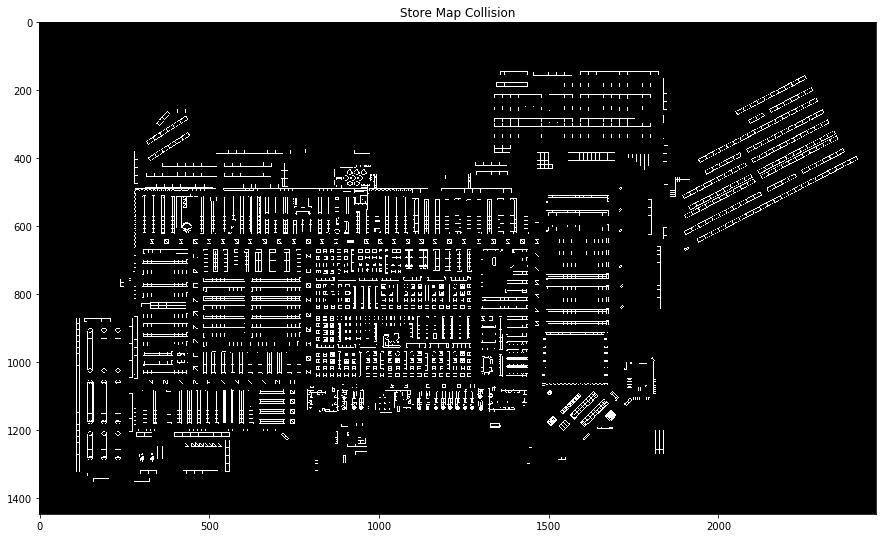

In [4]:
thresh, im_bw = cv2.threshold(im_gray, 254, 255, cv2.THRESH_BINARY_INV)
display_img(im_bw, title="Store Map Collision")

## Generating the Collision Map

Next, we'll use the contours to determine what regions are considered inaccessible.

In [5]:
im_bw.shape

(1448, 2466)

In [6]:
cv2.findContours?

In [9]:
print(cv2.__version__)

4.1.1


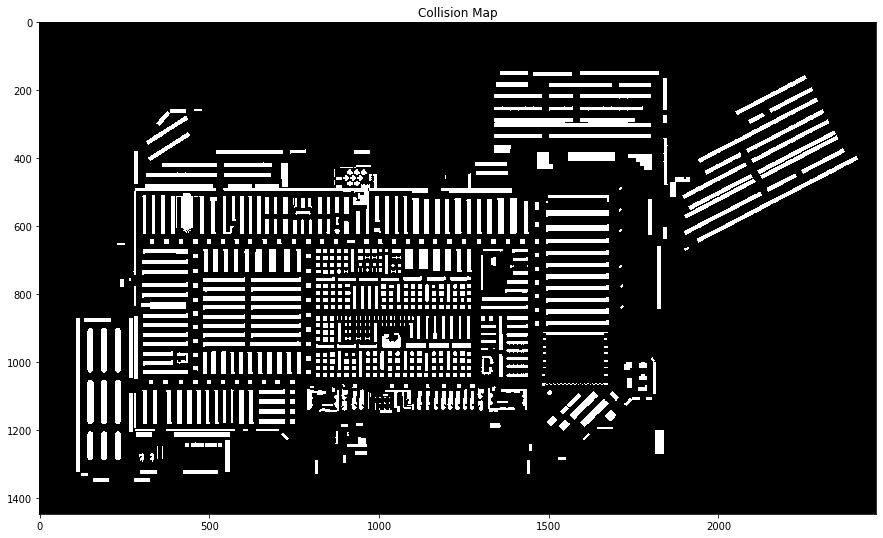

In [10]:
collision_map = im_bw.copy()
contour, hier = cv2.findContours(collision_map, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    cv2.drawContours(collision_map, [cnt], 0, 255, -1)
display_img(collision_map, title="Collision Map")

In [11]:
collision_map[1000:1010,600:710]

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

## Determining Target Points

Next, we'll find the target points by looking at the edges of our collision map and selecting non-zero points on those edges. These locations will eventually be manually overwrriten with 0s to make them accessible.

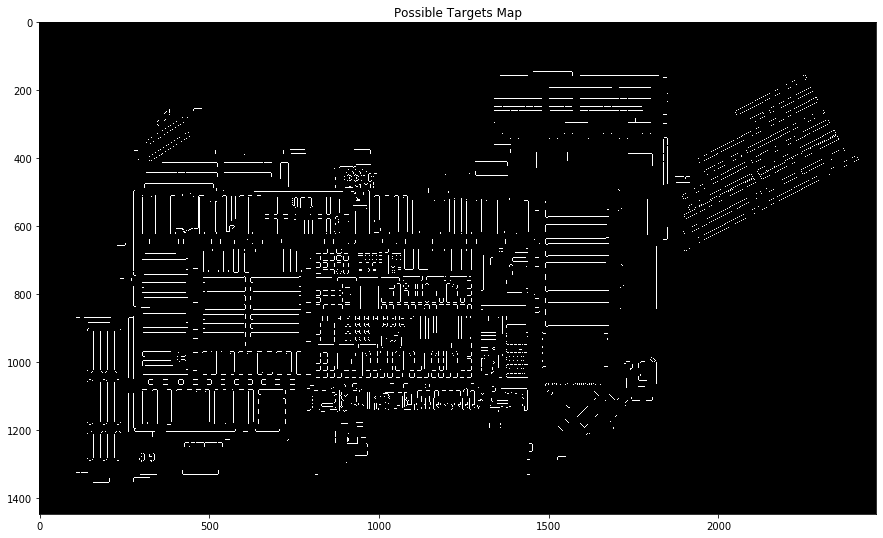

In [12]:
valid_targets = cv2.Laplacian(collision_map, cv2.CV_64F)
display_img(valid_targets, title="Possible Targets Map")

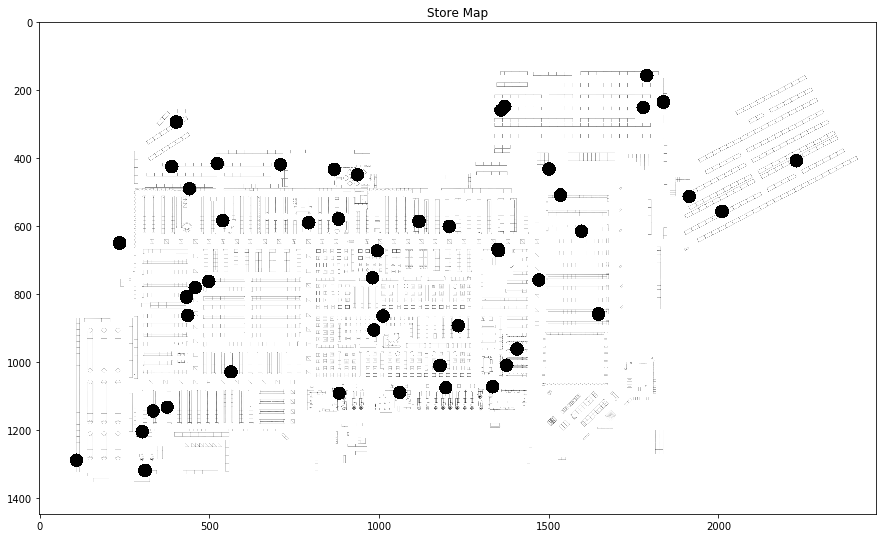

In [13]:
random.seed(target_seed)
im_targets = im_gray.copy()
ys, xs = valid_targets.nonzero()
target_indicies = random.sample(range(len(xs)), N_targets)
target_xs, target_ys = xs[target_indicies], ys[target_indicies]
for x, y in zip(target_xs, target_ys):
    cv2.circle(im_targets, (x, y), circle_draw_size, (0, 255, 0), -1)
display_img(im_targets)

## Generate the Traffic Map

Finally, we'll generate some noise to represent the traffic in the store. This noise represents the per-pixel difficulty of traveling in a particular region of the store. An ideal path is one which traverses all targets while minimizing sum of the path weights along the route. Note that impassable areas have a path weight of inifinity, so going through those points results in the worst possible score.

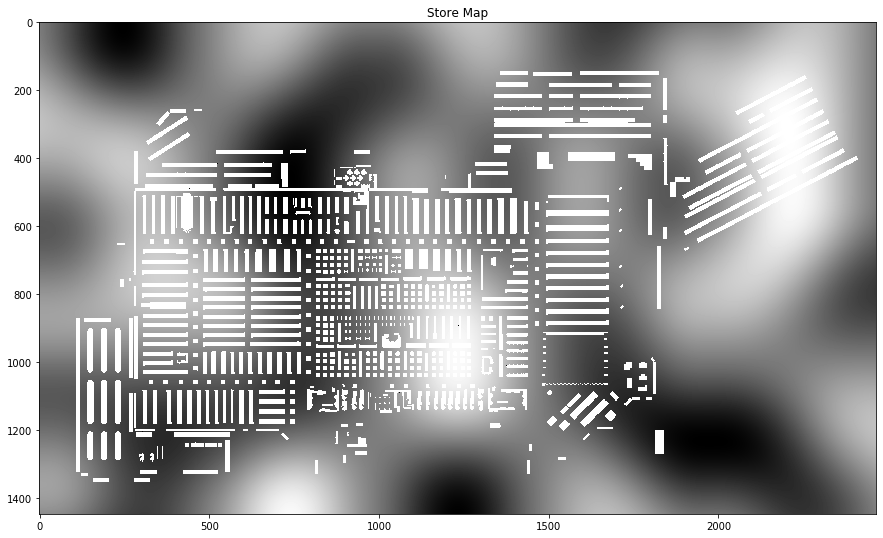

In [14]:
width, height = len(im_targets[0]), len(im_targets)
noise_img = generate_noise_image(width, height, seed=noise_seed)
noise_img = (noise_img - np.min(noise_img)) / (np.max(noise_img) - np.min(noise_img))

travel_friction = (~collision_map>0).astype(int) * noise_img
travel_friction[collision_map>0] = np.inf
for x, y in zip(target_xs, target_ys):
    travel_friction[y][x] = 0

display_img(travel_friction*255)

## Viewing the Final Objective

Now that we have the travel friction map (i.e. the map of the difficulty of traversing every point on the image) and a list of the goal points, a path can be generated which minimizes the sum of the weights while visiting points adjacent to every goal point. Note that diagonal motion is not allowed - only horizontal or vertical moves are permitted. Also note that all goal points are considered "0" weight, meaning there is no cost for visiting the goal point.

The circles in this image to not indicate weights - they are markers. The travel_friction image is the one upon which you will be judged. Remember this image will have random noise and points, so do not assume it will be identical each time.

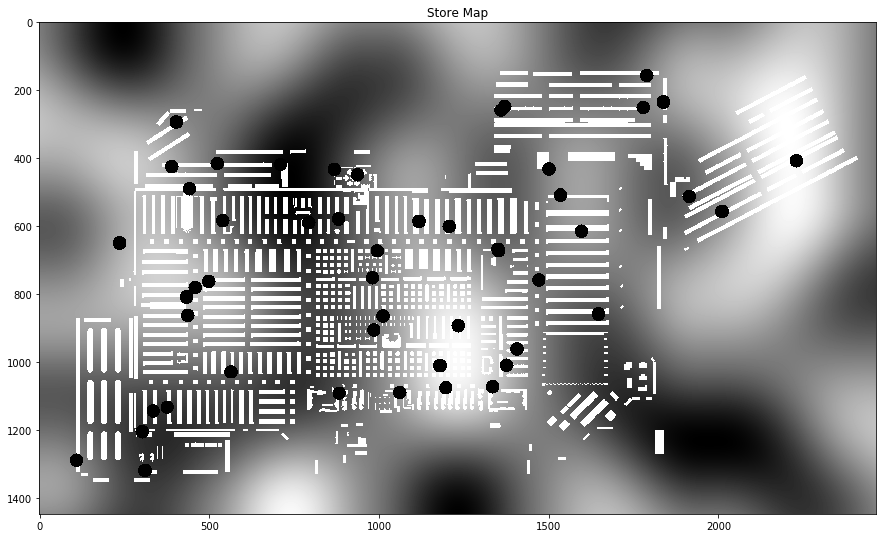

In [15]:
goal_image = travel_friction.copy()
for x, y in zip(target_xs, target_ys):
    cv2.circle(goal_image, (x, y), circle_draw_size, (0, 0, 0), -1)
display_img(goal_image*255)

# Problem Function

This function will return, given two random seeds, a traffic map and a set of target locations. You can use any seeds you like during development, but a fixed list of seeds will be used to test every participant. Note that a variable number of targets will be used as well in testing.

In [16]:
def get_traffic_map_and_targets(N, traffic_seed, target_seed, origin=0, scale_factor=5):
    # Load store map
    im_gray = cv2.imread('1150.png', cv2.IMREAD_GRAYSCALE)
    # Binarize
    thresh, im_bw = cv2.threshold(im_gray, 254, 255, cv2.THRESH_BINARY_INV)
    # Fill holes to make impassable areas
    collision_map = im_bw.copy()
    contour, hier = cv2.findContours(collision_map, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(collision_map, [cnt], 0, 255, -1)
    # Edge detect to generate valid targets
    valid_targets = cv2.Laplacian(collision_map, cv2.CV_64F)
    # Generate random targets
    random.seed(target_seed)
    im_targets = im_gray.copy()
    ys, xs = valid_targets.nonzero()
    target_indicies = random.sample(range(len(xs)), N_targets)
    target_xs, target_ys = xs[target_indicies], ys[target_indicies]
    # Generate noise image for traffic
    width, height = len(im_targets[0]), len(im_targets)
    noise_img = generate_noise_image(width, height, seed=noise_seed, origin=origin, scale_factor=scale_factor)
    noise_img = (noise_img - np.min(noise_img)) / (np.max(noise_img) - np.min(noise_img))
    # Merge noise and collisions
    travel_friction = (~collision_map>0).astype(int) * noise_img
    # Enforce collision map infinite condition
    travel_friction[collision_map>0] = np.inf
    # Make targets passable
    for x, y in zip(target_xs, target_ys):
        travel_friction[y][x] = 0
    # Return the friction map and the target points
    return travel_friction, list(zip(target_xs, target_ys))

## Scoring and Evaluation

The following function is used for scoring and evaluation. It will throw errors if you do not follow the path rules or if you don't traverse all of the target points. If you pass those two conditions, it will generate a score whose value should be minimized. Note that this score will be infinity if the path traverses an impassable location.

In [17]:
def evaluate_path(traffic_map, target_points, path_points):
    # Confirm the path is contiguous
    for i in range(0, len(path_points) - 1):
        if np.abs(path_points[i][0] - path_points[i+1][0]) + np.abs(path_points[i][1] - path_points[i+1][1]) > 1:
            raise ValueError('Error in path between {0} @ {1} and {2} @ {3}. The path given by path_points has jumps - the path must never move more than 1 square in either the horizontal or vertical direction. Diagonal is not allowed.'.format(i, path_points[i], i+1, path_points[i+1]))
    # Confirm all points were visited
    for idx, tp in enumerate(target_points):
        if tp not in path_points:
            raise ValueError('Not all target points were visited. Point {0} @ {1} was not visited. Stopping evaluation.'.format(idx, tp))
    # Determine the score
    score = 0
    for pp in path_points:
        score += traffic_map[pp[1]][pp[0]]
    return score

## Visualization and Examples

Finally, it is recommended you visualize both the target and your paths to understand the choices your system makes.

In [18]:
def draw_path(img, path, color=1.0):
    tmp = img.copy()
    for p in path:
        tmp[p[1]][p[0]] = color
    return tmp

In [19]:
def my_path(startpoint):
    """
    Input:
        startpoint: point at which our path finding starts
    """

# Problem approach

Since the image processing is effectively already done for us, the task at hand is thus to parse the processed image and translate it into a graph, which we can then tackle using well established graph algorithms.

The main issue is that, though we can immediately identify that this problem is a type of travelling salesman problem, we must find some way to calculate edge lengths in the graph.

The first naive approach would be to simply ignore the traffic map and simply calculate Manhattan distance between each pair of points. 
Clearly, this is heavily flawed and does not accurately reflect the problem.
In order to incorporate the traffic map, however, requires the choice of a specific path for each pair of targets. 
This, then, poses a significant challenge. 
Because there is a large choice of possible paths between each point (many of which would be equivalent in terms of Manhattan distance), we must develop a way to choose one of the many possible paths to be the edge. 
If we are to minimize the total travel cost for our overall algorithm, it is most logical to choose the path with the lowest possible cost as the edge between two given targets.

This choice presents the first major challenge. 
To find the shortest path between two given points immediately suggests the use of an algorithm such as Dijkstra's, A star, or Floyd-Warshall. 
However, it is computationally intractable to actually run any of these algorithms for every single pair of targets.
We know that the entire $m*n$ image consists our graph, and that the runtime of A star is $O(b^d)$ where $b$ is the branching factor and $d$ is the depth of the solution. 
Given some number of targets $t$, and noting that the maximum depth of a solution would be $m+n$, the runtime of an exhaustive pairwise search would be $O(t\cdot4^{m+n})$, which is far too expensive.
Therefore, it is necessary to develop a method to, for a given target $i$, pick a subset of the target set $J_i \subset T$ such that $J_i$ is a small set of likely next nearest neighbors of $i$ (in other words, a set of the points that $i$ is most likely to succeed or be a successor of in the TSP solution). 
With such a set $J_i$, we can then calculate $\text{distance}(i,j)$ for $j\in J_i$ and set the remaining targets $t \notin J_i$ to be infinity. In our attempts at a solution, we present a few approaches to generating $J_i$, including a clustering method and a nearest neighbor search method.

After the sets $J_i ~\forall i$ are determined, then we simply run A* for each pair $(i, j), j\in J_i$. 
After A* returns distances for each candiate pair, and we have filled in infinite values for the other pairs, then we can run the Travelling Salesman algorithm and generate a shortest path tour of the targets.


# Algorithm description

1) Given a point of interest, $i$, filter out a subset of points $J$ around point $i$ 

2) Run a shortest path algorithm between $i$ and $j \in J$, filling in the $(i, j)$ entry of the distance matrix $D$.

3) Fill in all $(i, k \neq j)$ in $D$ to be  $\infty$.

4) Plug this complete distance matrix $D$ into an approximate solution for TSP. 

# Filtering

## Nearest neighbor

I'll start by defining a specific start point. Let's say the door is at point (300, 1400)
We'll just say that this is also a "target" in our TSP graph, so we need to find the nearest target to the start point and just find the nearest neighbor to begin traversing the actual targets.

In [20]:
def l1(p1, p2):
    from scipy.linalg import norm
    """
    Takes in two lists of form [x_i, y_i]
    Returns unweighted L1 norm.
    """
    p1, p2 = np.array(p1), np.array(p2)
    return norm(p1 - p2, ord = 1)

# num_points = len(target_xs)

my_start = [300, 1400]
targets = zip(target_xs, target_ys)
targets = [list(target) for target in targets] #convert list of tuples to list of lists
targets = [my_start] + targets

Sanity check for distance function for small number of points:

[[   0.  344. 1589. 2704. 1784. 2083. 1304. 1053. 1536.  199.]
 [ 344.    0. 1245. 2360. 1440. 1739.  960.  709. 1192.  145.]
 [1589. 1245.    0. 1115.  633.  826.  285.  536.   85. 1390.]
 [2704. 2360. 1115.    0.  920.  621. 1400. 1651. 1168. 2505.]
 [1784. 1440.  633.  920.    0.  299.  636. 1087.  718. 1585.]
 [2083. 1739.  826.  621.  299.    0.  829. 1280.  911. 1884.]
 [1304.  960.  285. 1400.  636.  829.    0.  451.  232. 1105.]
 [1053.  709.  536. 1651. 1087. 1280.  451.    0.  483.  854.]
 [1536. 1192.   85. 1168.  718.  911.  232.  483.    0. 1337.]
 [ 199.  145. 1390. 2505. 1585. 1884. 1105.  854. 1337.    0.]]


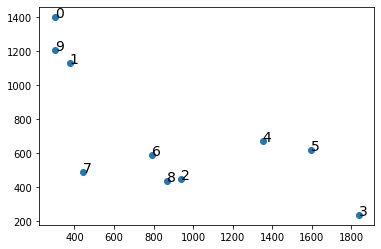

In [21]:
test_points = 10
test_targets = targets[:test_points]

def generate_D(targets):
    """ 
    Takes in a list of targets and generates 
    """
    test_points = len(targets)
    distances = np.zeros((test_points, test_points))
    for i, target in enumerate(targets):
        for j,othertarget in enumerate(targets):
            if i == j:
                continue        
            distances[i, j] = l1(target, othertarget)
    return distances

test_distances = generate_D(test_targets)
print(test_distances)

plt.scatter([i for i, j in targets[:test_points]], [j for i, j in targets[:test_points]])

for i in np.arange(test_points):
    plt.annotate(str(i), ([i for i, j in targets[:test_points]][i], [j for i, j in targets[:test_points]][i]), size = 14)

In [22]:
target_distances = generate_D(targets)

target_distances

array([[   0.,  344., 1589., ...,  813., 1210., 1180.],
       [ 344.,    0., 1245., ...,  623.,  866.,  836.],
       [1589., 1245.,    0., ...,  902.,  689.,  505.],
       ...,
       [ 813.,  623.,  902., ...,    0.,  523., 1005.],
       [1210.,  866.,  689., ...,  523.,    0., 1194.],
       [1180.,  836.,  505., ..., 1005., 1194.,    0.]])

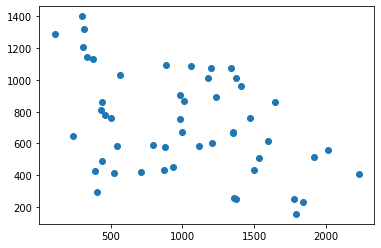

In [23]:
plt.scatter([i for i, j in targets], [j for i, j in targets])

Then, I simply filter this distance graph to only allow some nearest neighbors to remain finite values, subject to the constraint that we must ensure a connected graph.

## Clustering

In this approach, we use Kmeans to cluster all of our target points. We then run exhaustive A star to calculate the distances between all points within a single cluster. After generating the distance matrix for each subgraph, we then use a Euclidean search method to approximate a pair of connecting points for each pair of clusters. 

In [98]:
from sklearn.cluster import KMeans

nclusters = 8

kclusters = KMeans(nclusters).fit(targets)

kclusters.cluster_centers_

array([[ 439.        ,  815.83333333],
       [1438.66666667,  695.83333333],
       [1927.83333333,  353.5       ],
       [ 289.83333333, 1248.33333333],
       [ 940.        ,  580.28571429],
       [1168.        ,  997.8       ],
       [ 502.5       ,  438.        ],
       [1442.75      ,  362.        ]])

In [99]:
kclusters.cluster_centers_

array([[ 439.        ,  815.83333333],
       [1438.66666667,  695.83333333],
       [1927.83333333,  353.5       ],
       [ 289.83333333, 1248.33333333],
       [ 940.        ,  580.28571429],
       [1168.        ,  997.8       ],
       [ 502.5       ,  438.        ],
       [1442.75      ,  362.        ]])

In [100]:
#output of tsp will be look the same as cluster_centers_, just shuffled

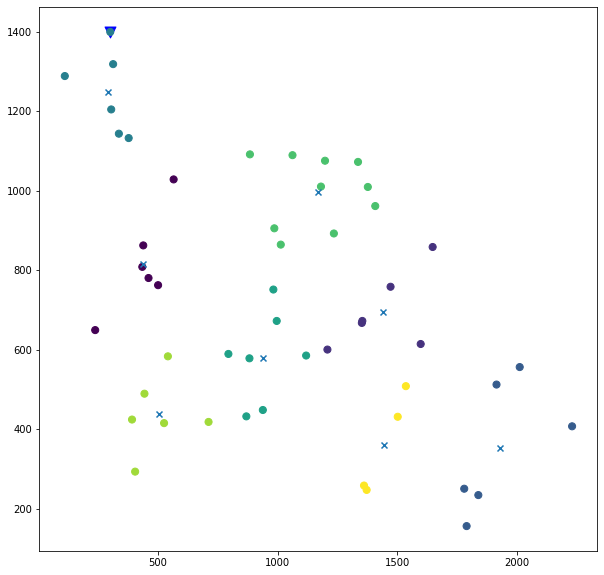

In [128]:
plt.figure(figsize=(10,10))
y_kmeans = kclusters.predict(targets)
plt.scatter(targets[0][0], targets[0][1], marker = 'v', color = 'b', s = 120)
plt.scatter(np.array(targets)[:, 0], np.array(targets)[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kclusters.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker = 'x');

## Cluster TSP

In [102]:
from tspy import TSP
import numpy as np
from tspy.solvers import TwoOpt_solver

def getTour(dist_array, dict_centroids):
    tsp = TSP()
    tsp.read_mat(dist_array)
    two_opt = TwoOpt_solver(initial_tour='NN', iter_num=100)
    two_opt_tour = tsp.get_approx_solution(two_opt)
    
    tour = tsp.get_best_solution() #data type List
    
    return [dict_centroids[str(point)] for point in tour]

def getDistArray(centroids_array):
    x, y = centroids_array.shape
    n_centroids = len(centroids_array)
    dict_centroids = {}
    
    for idx, i in enumerate(centroids_array):
        dict_centroids[str(idx)] = i
    
    dist_array = np.zeros((n_centroids, n_centroids))
    
    for idxA, centroidA in enumerate(centroids_array):
        for idxB, centroidB in enumerate(centroids_array):
            dist_array[idxA, idxB] = abs(centroidA[0]-centroidB[0]) + abs(centroidA[1]-centroidB[1])
    
    return dist_array, dict_centroids

centroids = np.array([[ 940.        ,  580.28571429],
      [1411.66666667,  313.        ],
      [ 439.        ,  815.83333333],
      [ 289.83333333, 1248.33333333],
      [1927.83333333,  353.5       ],
      [1168.        ,  997.8       ],
      [1452.57142857,  669.14285714],
      [ 502.5       ,  438.        ]])

dist_array, dict_centroids = getDistArray(centroids)

tour = getTour(dist_array, dict_centroids)


The cost is 5431.23809524.
The best solution is given by TwoOpt_solver with score 5431.23809524


## Cluster corner detection

In [2]:
gray = np.float32(traffic_im_tiny)
dst = cv2.cornerHarris(gray, 3, 3, 0.04)
print(dst)

NameError: name 'np' is not defined

In [1]:
traffic_im_tiny_color = cv2.cvtColor(np.float32(traffic_im_tiny), cv2.COLOR_GRAY2BGR)
traffic_im_tiny_color[dst > 0.01 * dst.max()] = [0, 0, 255]
display_img(traffic_im_tiny_color)

NameError: name 'cv2' is not defined

# Distance matrix population

Given input from the above subset generation approaches, we then run the A star algorithm each pair of points. 

In [ ]:
class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position
    
    def __del__(self):
        print('xxxxx')

def astar(maze, start, end):
    """Returns a list of tuples as a path from the given start to the given end in the given maze"""

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
                
            return path[::-1] # Return reversed path

        # Generate children
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]: # Adjacent squares

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)
            



def astar_run(maze, tour):
    final_path = []
    counter=0
    for A, B in zip(tour[:-1], tour[1:]):
        #print(A, B)
        path = astar(maze, A, B)
        counter+=1
        #if counter >= 4:
         #   break;
        final_path.append(path)
        print(counter)
    return(final_path)

def astar_run2():
    maze = [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

    start = (0, 0)
    end = (7, 6)

    path = astar(maze, start, end)
    print(path)
   

# Run TSP given D

# Evaluation

In [104]:
tsp_clusters = tour

In [113]:
tsp_clusters = np.array(tsp_clusters)
tsp_clusters

array([[ 940.        ,  580.28571429],
       [ 502.5       ,  438.        ],
       [ 439.        ,  815.83333333],
       [ 289.83333333, 1248.33333333],
       [1168.        ,  997.8       ],
       [1452.57142857,  669.14285714],
       [1927.83333333,  353.5       ],
       [1411.66666667,  313.        ],
       [ 940.        ,  580.28571429]])

In [114]:
minpoints = []
for i, cluster in enumerate(clusterlists[:-1]):
    minpoint = cluster[0]
    mindist = l1(minpoint, tsp_clusters[i+1])
    
    for point in cluster:
        thisdist = l1(point, tsp_clusters[i + 1])
        if thisdist < mindist:
            minpoint = point
            mindist = thisdist
            
    minpoints+=[minpoint]
minpoints = np.array(minpoints)

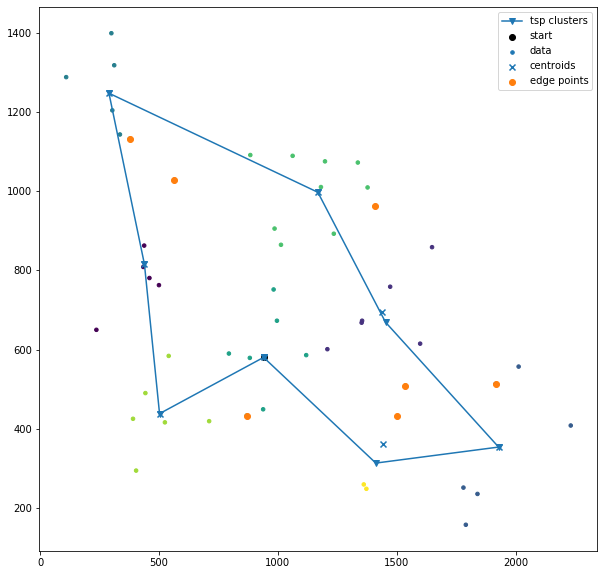

In [120]:
plt.figure(figsize=(10, 10))
plt.scatter(tsp_clusters[0,0], tsp_clusters[0,1], color = "k", label = "start")
y_kmeans = kclusters.predict(targets)
plt.plot(tsp_clusters[:,0],tsp_clusters[:,1], marker = "v", label = "tsp clusters")
plt.scatter(np.array(targets)[:, 0], np.array(targets)[:, 1], c=y_kmeans, s=50, cmap='viridis', marker = '.', label = "data")

centers = kclusters.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker = 'x', label = "centroids");

plt.scatter(minpoints[:, 0], minpoints[:, 1], label = "edge points")
plt.legend();

In [57]:
kclusters.labels_

array([3, 3, 0, 4, 6, 6, 0, 7, 0, 3, 5, 4, 5, 2, 1, 4, 7, 7, 6, 5, 5, 1,
       2, 4, 3, 3, 5, 6, 0, 5, 5, 6, 4, 4, 3, 5, 6, 0, 6, 0, 0, 1, 7, 2,
       7, 2, 2, 5, 2, 7, 5], dtype=int32)

In [58]:
clusterlists = []
for cluster in range(nclusters):
    clusterlist = []
    for i in range(len(kclusters.labels_)):
        if cluster == kclusters.labels_[i]:
            clusterlist += [targets[i]]
    clusterlists += [clusterlist]
            

In [59]:
clusterlists

[[[938, 449],
  [794, 590],
  [869, 433],
  [1119, 586],
  [996, 673],
  [882, 579],
  [982, 752]],
 [[1361, 259], [1372, 248], [1502, 432]],
 [[438, 863], [565, 1029], [434, 809], [460, 781], [500, 763], [237, 650]],
 [[300, 1400],
  [377, 1133],
  [304, 1205],
  [336, 1144],
  [312, 1319],
  [110, 1289]],
 [[1839, 235],
  [2231, 408],
  [1780, 251],
  [2012, 557],
  [1790, 157],
  [1915, 513]],
 [[1181, 1011],
  [1198, 1076],
  [1408, 962],
  [1062, 1090],
  [1377, 1010],
  [1235, 893],
  [1336, 1073],
  [1013, 865],
  [884, 1092],
  [986, 906]],
 [[1352, 668],
  [1598, 615],
  [1208, 601],
  [1648, 859],
  [1354, 673],
  [1472, 759],
  [1536, 509]],
 [[443, 490], [711, 419], [541, 584], [525, 416], [391, 425], [404, 294]]]

In [25]:
# path = my_path()
display_img(draw_path(map_img, path, color=1)*255)
evaluate_path(map_img, [path[0], path[20]], path)

NameError: name 'map_img' is not defined